<a href="https://colab.research.google.com/github/kevin7548/WCDL/blob/main/Modeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import


In [1]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

import os
os.chdir('/content/drive/MyDrive/Colab Notebooks/WCDL')

Mounted at /content/drive


In [2]:
!pip install cartopy xarray
!pip install tensorflow
!pip install keras-tuner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.7/11.7 MB 101.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 4.3 MB/s eta 0:00:00


In [3]:
import numpy as np
import pandas as pd
from pandas import DataFrame
from pandas import concat
import seaborn as sns

import xarray as xr

import matplotlib.pyplot as plt
import scipy.interpolate as interp
import cartopy.crs as ccrs

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.model_selection import KFold
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dropout, Dense, GRU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

import keras
from keras.models import load_model

from math import sqrt
import itertools
import time
from collections import defaultdict

import warnings
warnings.filterwarnings('ignore')

In [4]:
# Define time and coordinates
train_time = pd.date_range(start='1/1/1979', end='12/1/2014', freq='MS') #36년(432)
test_time = pd.date_range(start='1/1/2015', end='12/1/2023', freq='MS') #9년(108)
all_time = pd.date_range(start='1/1/1979', end='12/1/2023', freq='MS') #45년(540)

#lon = np.linspace(-180, 177.5, 144)
#lat = np.linspace(90.0, -90.0, 73)
lon = np.linspace(-180, 180, 241)
lat = np.linspace(-90, 90, 121)

In [5]:
# Load Seoul's monthly temperature data
kmt = xr.open_dataset('korea_mean_temp.nc')['t2m'].sel(valid_time=train_time)
df_kmt = pd.DataFrame(index=range(len(kmt)))
df_kmt['kmt'] = kmt

# Defined Functions

## 1. Stepwise

In [6]:
# 변수 선정을 위한 함수
def stepwise(var,dataset,y):
  selected_var = [] ## 선택된 변수들
  sl_enter = 0.1#0.05
  sl_remove = 0.1#0.05

  sv_per_step = [] ## 각 스텝별로 선택된 변수들
  adjusted_r_squared = [] ## 각 스텝별 수정된 결정계수
  steps = [] ## 스텝
  step = 0

  while len(var) > 0:
    remainder = list(set(var) - set(selected_var))
    pval = pd.Series(index=remainder) ## 변수의 p-value
    ## 기존에 포함된 변수와 새로운 변수 하나씩 돌아가면서
    ## 선형 모형을 적합한다.
    for col in remainder:
        X = dataset[selected_var+[col]]
        X = sm.add_constant(X)
        model = sm.OLS(y,X).fit()
        pval[col] = model.pvalues[col]

    min_pval = pval.min()
    if min_pval < sl_enter: ## 최소 p-value 값이 기준 값보다 작으면 포함
      selected_var.append(pval.idxmin())
      ## 선택된 변수들에대해서
      ## 어떤 변수를 제거할지 고른다.
      while len(selected_var) > 0:
          selected_X = dataset[selected_var]
          selected_X = sm.add_constant(selected_X)
          selected_pval = sm.OLS(y,selected_X).fit().pvalues[1:] ## 절편항의 p-value는 뺀다
          max_pval = selected_pval.max()
          if max_pval >= sl_remove: ## 최대 p-value값이 기준값보다 크거나 같으면 제외
              remove_variable = selected_pval.idxmax()
              selected_var.remove(remove_variable)
          else:
              break
      step += 1
      steps.append(step)
      adj_r_squared = sm.OLS(y,sm.add_constant(dataset[selected_var])).fit().rsquared_adj
      adjusted_r_squared.append(adj_r_squared)
      sv_per_step.append(selected_var.copy())
    else:
      break

  fig = plt.figure(figsize=(7,7))
  fig.set_facecolor('white')

  col = (0., 70/255, 42/255)
  font_size = 8
  # plt.xticks(steps[:],[f'{s}\n' for s in steps]) #+'\n'.join(sv_per_step[i]) for i,s in enumerate(steps)], fontsize=8)
  plt.plot(steps[:],adjusted_r_squared[:], marker='o',markersize = 3, c=col,alpha=0.6)
  plt.ylabel('Adjusted R Squared',fontsize=font_size)
  plt.grid(True)
  plt.show()

  return sv_per_step

## 2. Heatmap

In [7]:
def heatmap(data1):
  cm = np.corrcoef(data1.values.T)

  plt.figure(figsize = (15,8))
  sns.heatmap(cm, cbar=True, cmap='vlag', vmin=-1.0, vmax=1.0, annot=True, square=True, fmt='.2f', annot_kws={'size':10},
            yticklabels=data1.columns, xticklabels=data1.columns)
  plt.show()

  kc_vif = pd.DataFrame()
  kc_vif["VIF"] = [variance_inflation_factor(data1.values, i) for i in range(data1.shape[1])]
  kc_vif["features"] = data1.columns
  return kc_vif

## 3. Time lag

In [8]:
# 시계열 데이터의 지연성을 고려하기 위한 함수
# 데이터 프레임을 shift하면서 하나의 행에 지난 시간의 데이터까지 모두 들어가도록 함
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()

	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]

	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]

	agg = concat(cols, axis=1)
	agg.columns = names

	if dropnan:
		agg.dropna(inplace=True)
	return agg

# Correlation

## 1. Load Data

In [ ]:
# Load nc data
f_clm = xr.open_dataset('new_clm_lag.nc').sel(time=train_time)
f_idx = xr.open_dataset('clm_idx.nc').sel(time=train_time)

idx_vars = list(f_idx.data_vars)
upper_idx_vars = [var.upper() for var in idx_vars]
rename_dict = dict(zip(idx_vars, upper_idx_vars))
f_idx = f_idx.rename(rename_dict)

combined_df = pd.DataFrame(index=range(len(df_kmt)), columns=list(f_idx.data_vars)+list(f_clm.data_vars))

for f in [f_clm, f_idx]:
    vlist = list(f.data_vars)
    for v in f.data_vars:
        combined_df[v] = f[v].values

combined_df

,AAO,AMMSST,AMON.US.LONG,AO,EA,ESPI,GMSST,MEIV2,NAO,NINA1.ANOM,...,mslp_prs,mslp_uyg,icec_can,icec_ant,mtnlwr_can,mtnlwr_ant,t2m_and,t2m_can,snowc_eura,snowc_and
0,0.209,1.15,-0.205,-2.233,-0.79,1.01533,0.09,0.47,-2.12,0.16,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.356,2.50,-0.164,-0.697,-0.20,0.70502,-0.13,0.29,-1.20,-0.58,...,NaN,103301.0000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.899,2.37,-0.241,-0.814,-0.10,0.17286,0.24,-0.05,0.41,-0.58,...,NaN,102269.5625,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0.678,2.16,-0.250,-1.157,0.15,-0.15151,0.23,0.21,-2.01,0.15,...,NaN,101963.1875,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0.724,2.42,-0.130,-0.250,-0.83,-0.09556,-0.03,0.27,-0.90,-0.13,...,NaN,101338.4375,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
427,-0.059,-0.34,0.313,-0.371,-1.69,0.14441,0.92,0.23,-2.28,0.89,...,101657.2500,100110.6250,0.949768,0.000000,-152.718262,-220.593262,291.328186,241.486374,100.000000,4.921875
428,-1.119,1.80,0.288,0.102,0.47,0.21027,1.11,-0.09,1.72,0.80,...,101339.6875,100443.1250,0.923279,0.000000,-160.384766,-207.654297,289.798889,246.336014,99.882812,29.531250
429,-0.039,3.18,0.270,-1.134,-0.37,0.55725,1.02,0.12,-0.87,0.69,...,101094.0000,101022.9375,0.875000,0.072449,-176.488281,-201.718750,286.992920,255.410904,20.716797,44.283203
430,-0.519,3.10,0.043,-0.530,1.28,0.15872,0.86,0.37,0.58,0.80,...,100613.5625,101924.8750,0.529633,0.602661,-202.266846,-190.501221,285.152771,266.621521,8.236328,97.541016


In [ ]:
#vlist = np.hstack([list(f_clm.data_vars), list(f_idx.data_vars)])
vlist = list(f_clm.data_vars) + list(f_idx.data_vars)
corr = np.zeros([len(vlist), 6])

for i, v in enumerate(vlist):
    corr[i,:] = np.array([np.corrcoef(combined_df[v].values[12+x::12][:df_kmt[13::12].shape[0]], df_kmt[13::12].T)[0][1] for x in range(0,-6,-1)])

#for i, v in enumerate(vlist):
#    corr[i,:] = np.array([np.corrcoef(combined_df[v].values[12+x::12][:df_kmt[17::12].shape[0]], df_kmt[17::12].T)[0][1] for x in range(4,-2,-1)])

In [ ]:
vals = pd.DataFrame(np.full([len(vlist), 6], np.nan))
maxcorr = []

for i in range(len(vlist)):
    ind = None; value=0
    for j in range(6):
        if np.abs(corr[i,j]) > value:
            ind = j
            value=np.abs(corr[i,j])
    vals.iloc[i,ind] = str(np.round(corr[i,ind], 2))
    maxcorr.append(ind)

vals = vals.replace(np.nan, '').values
vals

array([['', '', '', '', '-0.36', ''],
       ['', '', '', '', '0.12', ''],
       ['-0.39', '', '', '', '', ''],
       ['', '', '', '', '0.12', ''],
       ['', '', '', '', '-0.27', ''],
       ['-0.14', '', '', '', '', ''],
       ['0.13', '', '', '', '', ''],
       ['', '', '', '0.43', '', ''],
       ['', '', '-0.21', '', '', ''],
       ['', '', '-0.35', '', '', ''],
       ['', '', '', '-0.18', '', ''],
       ['', '', '', '0.17', '', ''],
       ['', '', '0.27', '', '', ''],
       ['', '', '', '', '', '0.23'],
       ['', '0.24', '', '', '', ''],
       ['0.32', '', '', '', '', ''],
       ['0.37', '', '', '', '', ''],
       ['0.16', '', '', '', '', ''],
       ['', '', '', '-0.44', '', ''],
       ['0.2', '', '', '', '', ''],
       ['', '', '0.19', '', '', ''],
       ['', '', '', '', '0.16', ''],
       ['', '', '0.16', '', '', ''],
       ['0.13', '', '', '', '', ''],
       ['', '', '', '', '0.3', ''],
       ['', '', '', '', '', '-0.3'],
       ['0.12', '', '', '', '', 

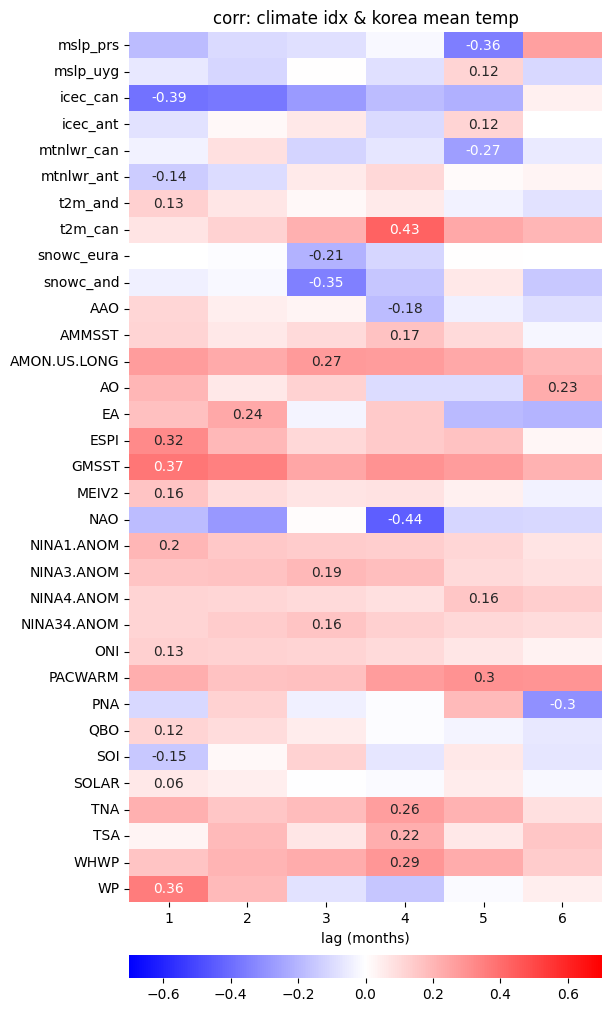

In [ ]:
fig = plt.figure(figsize=(6,10), constrained_layout=True, facecolor='w')

plot = sns.heatmap(corr, cmap=plt.get_cmap('bwr'), vmin=-0.7, vmax=0.7, annot=vals, fmt='',
                   cbar_kws = dict(use_gridspec=False,location='bottom',pad=0.01))

plt.yticks(np.arange(0.5, len(vlist)+0.5, 1), labels=vlist, rotation=0)
plt.xlabel('lag (months)')
plt.xticks(np.arange(0.5,6.5,1), labels=np.arange(1,7))
plt.title('corr: climate idx & korea mean temp')
plt.show()

# Stepwise

In [ ]:
max(maxcorr)

5

In [ ]:
clmidx = pd.concat([df_kmt, combined_df], axis=1)
clmidx = clmidx.dropna(axis=0)
#for var, lag in zip(vlist, maxcorr):
#  clmidx[var] = clmidx[var].shift(lag+1)

#clmidx = clmidx.dropna(axis=0)
clmidx

,kmt,AAO,AMMSST,AMON.US.LONG,AO,EA,ESPI,GMSST,MEIV2,NAO,...,mslp_prs,mslp_uyg,icec_can,icec_ant,mtnlwr_can,mtnlwr_ant,t2m_and,t2m_can,snowc_eura,snowc_and
6,295.060516,2.412,1.16,-0.107,0.038,-0.44,-0.87678,0.02,-0.11,0.86,...,101882.6250,100530.0000,0.992371,0.000000,-164.512207,-219.937988,292.286438,244.563782,100.000000,0.000000
7,296.712433,0.546,-0.42,-0.128,-0.684,-0.42,0.65850,0.13,0.47,1.11,...,101479.5625,100389.2500,0.982666,0.000000,-147.814209,-212.931396,292.172607,237.248795,100.000000,0.726562
8,292.233582,0.629,-0.89,-0.122,-0.046,-0.26,-0.36576,0.26,0.38,1.13,...,101330.1875,100424.0625,0.969086,0.009644,-160.427246,-211.274902,290.392639,245.621170,100.000000,0.000000
9,287.965790,0.160,-0.26,-0.100,-1.243,0.65,-0.02439,0.26,0.23,0.18,...,101048.6875,101286.5625,0.915161,0.235443,-182.623291,-202.771729,288.138184,254.698746,100.000000,38.750000
10,279.439575,-0.423,0.08,-0.098,0.475,-1.54,-0.21269,0.28,0.53,0.42,...,100769.3125,101949.0625,0.607697,0.757202,-204.477295,-187.641357,285.787781,266.631531,45.302734,97.417969
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
427,296.198395,-0.059,-0.34,0.313,-0.371,-1.69,0.14441,0.92,0.23,-2.28,...,101657.2500,100110.6250,0.949768,0.000000,-152.718262,-220.593262,291.328186,241.486374,100.000000,4.921875
428,293.100922,-1.119,1.80,0.288,0.102,0.47,0.21027,1.11,-0.09,1.72,...,101339.6875,100443.1250,0.923279,0.000000,-160.384766,-207.654297,289.798889,246.336014,99.882812,29.531250
429,287.876556,-0.039,3.18,0.270,-1.134,-0.37,0.55725,1.02,0.12,-0.87,...,101094.0000,101022.9375,0.875000,0.072449,-176.488281,-201.718750,286.992920,255.410904,20.716797,44.283203
430,281.830841,-0.519,3.10,0.043,-0.530,1.28,0.15872,0.86,0.37,0.58,...,100613.5625,101924.8750,0.529633,0.602661,-202.266846,-190.501221,285.152771,266.621521,8.236328,97.541016


In [ ]:
# 행 걸러주기
month = [7,8,9,10,11,12]
month.extend(list(np.arange(1,13))*35)
clmidx['month'] = month
clmidx = clmidx[clmidx['month']==6]
freq12_JJA = clmidx.drop(['month'], axis=1)

freq12_JJA

,kmt,AAO,AMMSST,AMON.US.LONG,AO,EA,ESPI,GMSST,MEIV2,NAO,...,mslp_prs,mslp_uyg,icec_can,icec_ant,mtnlwr_can,mtnlwr_ant,t2m_and,t2m_can,snowc_eura,snowc_and
17,292.227875,0.286,3.64,0.096,0.722,-1.86,-0.13139,0.22,0.55,-0.07,...,101783.8750,100903.8750,0.920105,0.0,-160.271973,-215.400879,291.237549,241.272705,100.000000,9.992007e-15
29,291.316711,0.352,2.19,-0.070,-0.438,-0.34,-0.49371,0.32,-0.70,-0.15,...,101740.1875,100883.5625,0.931519,0.0,-160.025635,-215.650635,291.393127,242.891190,100.000000,1.367188e-02
41,291.829498,0.920,-0.30,-0.192,-1.180,2.17,0.43734,0.00,0.62,-1.34,...,101857.5000,100969.0000,0.930847,0.0,-171.328857,-220.133545,290.617737,245.088440,100.000000,7.226562e-02
53,291.323212,-0.263,1.25,-0.062,0.312,0.75,1.42148,0.24,1.98,1.31,...,101947.2500,100716.8750,0.960266,0.0,-157.178467,-216.639404,291.644623,238.429779,100.000000,1.998401e-14
65,292.492462,0.426,-2.65,-0.333,0.007,-0.17,-1.12579,-0.02,-0.66,-0.12,...,101839.7500,100657.3750,0.951965,0.0,-159.307373,-212.627686,291.656219,244.433563,99.929688,3.906250e-02
77,291.749573,-0.331,-0.62,-0.136,-0.347,1.06,-0.65110,0.22,-0.67,-0.50,...,101813.5000,100786.1250,0.965485,0.0,-153.935547,-222.521484,290.199707,242.352036,100.000000,1.953125e-03
89,291.627991,-0.619,-4.37,-0.270,0.535,-0.19,-0.20274,0.09,0.01,1.54,...,101804.1250,100588.0625,0.960571,0.0,-167.881104,-214.260010,290.331055,246.997070,100.000000,0.000000e+00
101,292.021637,-0.702,2.34,0.194,-0.710,-0.96,1.30243,0.49,2.07,-1.53,...,101921.8750,100920.9375,0.939301,0.0,-154.236084,-215.478271,291.303162,241.484787,100.000000,0.000000e+00
113,292.413605,-1.055,1.71,0.154,0.060,-1.14,-0.74217,0.51,-1.17,1.19,...,101918.7500,100879.5625,0.995636,0.0,-173.200684,-210.251465,291.370300,248.925003,100.000000,9.414062e-01
125,291.140564,1.995,0.35,0.078,0.345,-1.20,-0.00997,0.12,-0.99,0.03,...,101758.6875,100781.3125,0.964661,0.0,-157.816162,-214.620850,290.526093,241.545624,100.000000,4.492188e-02


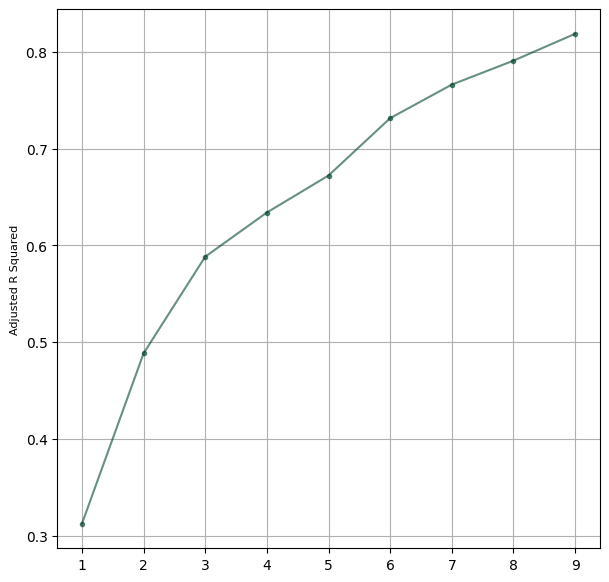

In [ ]:
# stepwise 구현
freq_x = freq12_JJA.drop(['kmt'], axis=1).copy()
freq_var = freq_x.columns
freq_step = stepwise(freq_var, freq_x, freq12_JJA['kmt'])

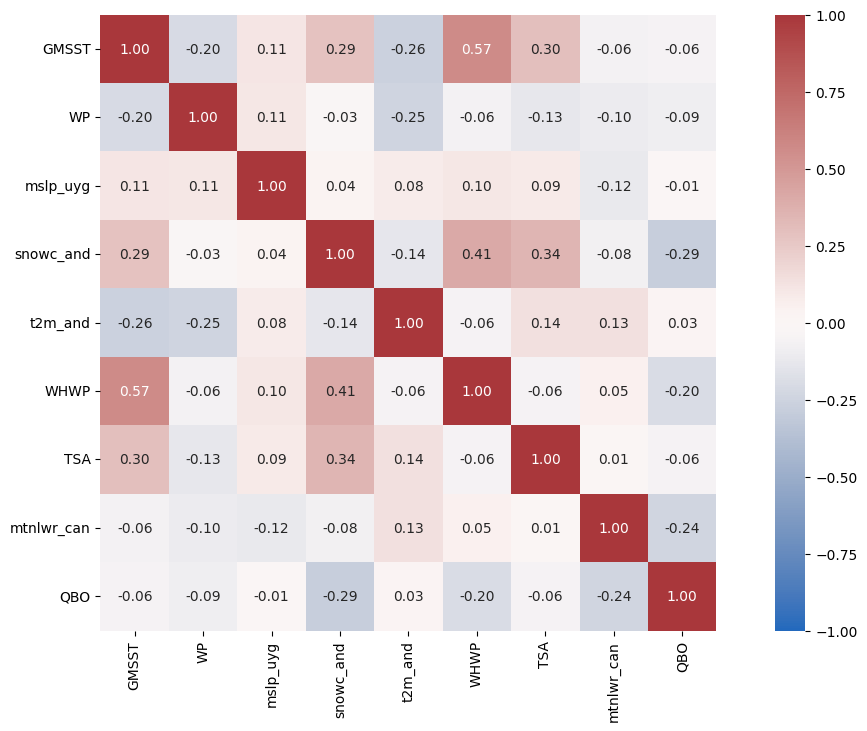

,VIF,features
0,10.688551,GMSST
1,1.239620,WP
2,247368.164715,mslp_uyg
3,1.802765,snowc_and
4,243342.539752,t2m_and
5,2.740988,WHWP
6,1.977013,TSA
7,791.406312,mtnlwr_can
8,1.317292,QBO


In [ ]:
kc_newh = freq_x[freq_step[-1]]
heatmap(kc_newh)

# MODEL

## 1. preprocessing

In [9]:
f = xr.open_dataset('korea_mean_temp.nc')['t2m']
df = pd.DataFrame(index=range(len(f)))
df['kmt'] = f

f1 = xr.open_dataset('clm_idx.nc')
indices1 = ['wp', 'whwp', 'tsa', 'qbo']

tmp1 = pd.DataFrame(index=range(len(f)))
for var in indices1:
  tmp1[var] = f1[var].values
tmp1.columns = [col.upper() for col in tmp1.columns]

f2 = xr.open_dataset('new_clm_lag.nc')
indices2 = ['snowc_eura']

tmp2 = pd.DataFrame(index=range(len(f)))
for var in indices2:
  tmp2[var] = f2[var].values

KMT_Data = pd.concat([df, tmp1, tmp2], axis=1)
KMT_Data = KMT_Data.dropna(axis=0)
KMT_Data

,kmt,WP,WHWP,TSA,QBO,snowc_eura
6,295.060516,1.72,-0.56,0.14,-21.27,100.000000
7,296.712433,1.57,-0.92,0.27,-22.24,100.000000
8,292.233582,0.35,-1.81,0.29,-22.70,100.000000
9,287.965790,0.71,0.41,0.05,-23.32,100.000000
10,279.439575,2.48,-0.37,0.06,-22.20,45.302734
...,...,...,...,...,...,...
535,298.353729,-0.37,11.09,0.50,-9.88,100.000000
536,295.263733,1.34,10.45,0.40,-13.58,99.947266
537,288.674561,-0.83,10.01,0.41,-16.98,80.451172
538,280.433716,0.59,8.57,0.91,-19.80,9.304688


In [10]:
# 시간 지연을 고려하여 1개월전부터 12개월전까지의 모든 값들을 넣어줌
n_features = len(KMT_Data.columns)
n_months = 6
ref_kmt = series_to_supervised(KMT_Data, n_months, 1)
endcolumn = (n_features)*(n_months+1)
ref_kmt.drop(ref_kmt.columns[list(np.arange((endcolumn-(n_features-1)), endcolumn))], axis=1, inplace=True)

In [11]:
# dataframe normalization
values = ref_kmt.values.astype('float32')
scaler = MinMaxScaler(feature_range=(-1, 1))
scaled = scaler.fit_transform(values)

new_kmt = pd.DataFrame(scaled, columns=ref_kmt.columns, index=ref_kmt.index)
new_kmt

,var1(t-6),var2(t-6),var3(t-6),var4(t-6),var5(t-6),var6(t-6),var1(t-5),var2(t-5),var3(t-5),var4(t-5),...,var4(t-2),var5(t-2),var6(t-2),var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var6(t-1),var1(t)
12,0.776421,0.460481,-0.30375,-0.096154,-0.633385,1.000000,0.886084,0.408935,-0.393834,0.028846,...,-0.173077,-0.674563,-0.093945,-0.522882,-0.120275,-0.312427,-0.250000,-0.443879,-1.000000,-0.874542
13,0.886084,0.408935,-0.34875,0.028846,-0.676334,1.000000,0.588755,-0.010309,-0.497382,0.048077,...,-0.250000,-0.443879,-1.000000,-0.874542,-0.718213,-0.303136,-0.375000,-0.139252,-1.000000,-0.816967
14,0.588755,-0.010309,-0.46000,0.048077,-0.696701,1.000000,0.305437,0.113402,-0.239093,-0.182692,...,-0.375000,-0.139252,-1.000000,-0.816967,-0.302405,-0.308943,-0.557692,0.058224,-1.000000,-0.421778
15,0.305437,0.113402,-0.18250,-0.182692,-0.724153,1.000000,-0.260576,0.721650,-0.329843,-0.173077,...,-0.557692,0.058224,-1.000000,-0.421778,0.243986,-0.356562,-0.480769,0.179987,-0.897578,-0.130556
16,-0.260576,0.721650,-0.28000,-0.173077,-0.674563,-0.093945,-0.522882,-0.120275,-0.311227,-0.250000,...,-0.480769,0.179987,-0.897578,-0.130556,0.116839,-0.303136,-0.336538,0.410671,-0.032227,0.291513
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
535,-0.566235,0.728522,-0.25500,0.298077,0.742307,-1.000000,-0.196156,0.092784,-0.159977,0.230769,...,0.317308,0.340270,0.999648,0.935154,0.326461,0.996516,0.288462,0.044499,1.000000,0.995041
536,-0.196156,0.092784,-0.09750,0.230769,0.792340,-0.884023,0.050955,-0.213058,0.066899,0.250000,...,0.288462,0.044499,1.000000,0.995041,-0.257732,1.000000,0.250000,-0.129068,1.000000,0.789911
537,0.050955,-0.213058,0.14625,0.250000,0.879123,-0.204023,0.377525,0.219931,0.304247,0.528846,...,0.250000,-0.129068,1.000000,0.789911,0.329897,0.925668,0.153846,-0.292894,0.998945,0.352488
538,0.377525,0.219931,0.40125,0.528846,0.718397,0.003633,0.677458,-0.017182,0.861547,0.317308,...,0.153846,-0.292894,0.998945,0.352488,-0.415808,0.874564,0.163462,-0.443436,0.609023,-0.194580


## 2. Modeling

In [13]:
def create_model(n_neurons, additional_layer, dropout, input_shape):
    """
    GRU 모델 생성 함수
    """
    model = Sequential()
    model.add(GRU(units=n_neurons, return_sequences=True, input_shape=input_shape))
    model.add(Dropout(dropout))

    if additional_layer:
        model.add(GRU(units=n_neurons, return_sequences=True))
        model.add(Dropout(dropout))

    model.add(GRU(units=n_neurons, return_sequences=True))
    model.add(Dropout(dropout))
    model.add(GRU(units=n_neurons, return_sequences=True))
    model.add(Dropout(dropout))
    model.add(GRU(units=n_neurons, return_sequences=False))
    model.add(Dropout(dropout))
    model.add(Dense(units=1, activation='linear'))

    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
    return model

def kfold_cross_validation(data, hyperparams, k=5):
    """
    K-Fold Cross Validation 수행
    """
    # 하이퍼파라미터 조합 생성
    param_combinations = list(itertools.product(*hyperparams.values()))
    param_names = list(hyperparams.keys())

    results = []
    best_score = float('inf')
    best_params = None

    print(f"총 {len(param_combinations)}개의 하이퍼파라미터 조합을 테스트합니다.")
    print("=" * 80)

    for i, params in enumerate(param_combinations):
        param_dict = dict(zip(param_names, params))

        print(f"조합 {i+1}/{len(param_combinations)}: {param_dict}")

        # K-Fold 설정
        kf = KFold(n_splits=k, shuffle=False)  # 시계열 데이터이므로 shuffle=False
        fold_scores = []

        fold_start_time = time.time()

        for fold, (train_idx, val_idx) in enumerate(kf.split(data)):
            print(f"  Fold {fold+1}/{k} 진행중...", end=" ")

            # 데이터 분할
            train_data = data.iloc[train_idx]
            val_data = data.iloc[val_idx]

            # 정규화
            train_values = train_data.values.astype('float32')
            val_values = val_data.values.astype('float32')

            scaler = MinMaxScaler(feature_range=(-1, 1))
            train_scaled = scaler.fit_transform(train_values)
            val_scaled = scaler.transform(val_values)

            # X, y 분할
            train_X, train_y = train_scaled[:, :-1], train_scaled[:, -1]
            val_X, val_y = val_scaled[:, :-1], val_scaled[:, -1]

            # 3D로 reshape
            train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
            val_X = val_X.reshape((val_X.shape[0], 1, val_X.shape[1]))

            # 모델 평가
            rmse, actual_epochs = evaluate_model(train_X, train_y, val_X, val_y, scaler,
                                param_dict['n_neurons'], param_dict['additional_layer'],
                                param_dict['n_batch_size'], param_dict['dropout'])

            fold_scores.append(rmse)
            print(f"RMSE: {rmse:.4f} (에포크: {actual_epochs})")

        # 평균 및 표준편차 계산
        mean_score = np.mean(fold_scores)
        std_score = np.std(fold_scores)

        fold_time = time.time() - fold_start_time

        result = {
            'params': param_dict,
            'mean_rmse': mean_score,
            'std_rmse': std_score,
            'fold_scores': fold_scores,
            'time': fold_time
        }
        results.append(result)

        print(f"  평균 RMSE: {mean_score:.4f} (±{std_score:.4f}) - 소요시간: {fold_time:.1f}초")

        # 최고 성능 업데이트
        if mean_score < best_score:
            best_score = mean_score
            best_params = param_dict
            print(f"  *** 새로운 최고 성능! ***")

        print("-" * 80)

    return results, best_params, best_score

In [ ]:
# 하이퍼파라미터 정의
hyperparameters = {
    'additional_layer': [True, False],
    'n_neurons': [32, 64, 128, 256],
    'n_batch_size': [64, 128, 256],
    'dropout': [0.0, 0.2]
}

# K-Fold Cross Validation 실행
print("K-Fold Cross Validation과 Hyperparameter Tuning을 시작합니다...")
print(f"데이터 크기: {new_kmt.shape}")

start_time = time.time()
results, best_params, best_score = kfold_cross_validation(new_kmt, hyperparameters, k=5)
total_time = time.time() - start_time

# 결과 출력
print("\n" + "=" * 80)
print("HYPERPARAMETER TUNING 결과")
print("=" * 80)

print(f"\n최고 성능:")
print(f"파라미터: {best_params}")
print(f"평균 RMSE: {best_score:.4f}")
print(f"총 소요시간: {total_time/60:.1f}분")

K-Fold Cross Validation과 Hyperparameter Tuning을 시작합니다...
데이터 크기: (529, 37)
총 48개의 하이퍼파라미터 조합을 테스트합니다.
조합 1/48: {'additional_layer': True, 'n_neurons': 32, 'n_batch_size': 64, 'dropout': 0.0}
  Fold 1/5 진행중... RMSE: 0.1379 (에포크: 16)
  Fold 2/5 진행중... 

RMSE: 0.0843 (에포크: 100)
  Fold 3/5 진행중... RMSE: 0.0740 (에포크: 57)
  Fold 4/5 진행중... RMSE: 0.0864 (에포크: 91)
  Fold 5/5 진행중... RMSE: 0.0754 (에포크: 67)
  평균 RMSE: 0.0916 (±0.0236) - 소요시간: 173.3초
  *** 새로운 최고 성능! ***
--------------------------------------------------------------------------------
조합 2/48: {'additional_layer': True, 'n_neurons': 32, 'n_batch_size': 64, 'dropout': 0.2}
  Fold 1/5 진행중... RMSE: 0.1027 (에포크: 72)
  Fold 2/5 진행중... RMSE: 0.0976 (에포크: 45)
  Fold 3/5 진행중... RMSE: 0.0751 (에포크: 67)
  Fold 4/5 진행중... RMSE: 0.0881 (에포크: 73)
  Fold 5/5 진행중... RMSE: 0.0914 (에포크: 57)
  평균 RMSE: 0.0910 (±0.0094) - 소요시간: 182.0초
  *** 새로운 최고 성능! ***
--------------------------------------------------------------------------------
조합 3/48: {'additional_layer': True, 'n_neurons': 32, 'n_batch_size': 128, 'dropout': 0.0}
  Fold 1/5 진행중... RMSE: 0.1048 (에포크: 100)
  Fold 2/5 진행중... RMSE: 0.0861 (에포크: 100)
  Fold 3/5 진행중... RMSE: 0.0704 (에포크: 97)
  Fold 4/5 진행중... RMSE: 0.0886 (에포크: 100)
  Fold 5/5 진

In [74]:
additional_layer = True
n_neurons = 256
n_batch_size = 64
dropout = 0.2

In [75]:
# 전체 데이터 분할
values = new_kmt.values.astype('float32')
scaler_final = MinMaxScaler(feature_range=(-1, 1))
scaled_final = scaler_final.fit_transform(values)

# 임시로 train_time이 없다면 데이터의 80%를 훈련용으로 사용
if 'train_time' not in globals():
    n_train_hours = int(len(scaled_final) * 0.8)
else:
    n_train_hours = 12 * (int(len(train_time)/12) - 1)

train_final = scaled_final[:n_train_hours, :]
test_final = scaled_final[n_train_hours:, :]

train_X_final, train_y_final = train_final[:, :-1], train_final[:, -1]
test_X_final, test_y_final = test_final[:, :-1], test_final[:, -1]

train_X_final = train_X_final.reshape((train_X_final.shape[0], 1, train_X_final.shape[1]))
test_X_final = test_X_final.reshape((test_X_final.shape[0], 1, test_X_final.shape[1]))

In [76]:
# 최고 모델 훈련
final_model = create_model(n_neurons, additional_layer,
                          dropout, (train_X_final.shape[1], train_X_final.shape[2]))

# EarlyStopping 콜백
final_early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=15,  # 최종 모델은 patience를 조금 더 크게
    restore_best_weights=True,
    verbose=1
)

print(f"최종 모델 훈련 중...")
final_history = final_model.fit(train_X_final, train_y_final, epochs=100,
                               batch_size=n_batch_size,
                               validation_data=(test_X_final, test_y_final),
                               verbose=1, shuffle=False, callbacks=[final_early_stopping])

# 최종 모델로 훈련 데이터에 대한 예측도 수행
print("훈련 데이터에 대한 예측 수행 중...")
try:
    # 훈련 데이터 예측
    yhat_train = final_model.predict(train_X_final, verbose=0)
    train_X2 = train_X_final.reshape((train_X_final.shape[0], train_X_final.shape[2]))

    # 훈련 데이터 역변환
    inv_yhat_train = np.concatenate((yhat_train, train_X2), axis=1)
    inv_yhat_train = scaler_final.inverse_transform(inv_yhat_train)[:,0]

    train_y2 = train_y_final.reshape((len(train_y_final), 1))
    inv_y_train_final = np.concatenate((train_y2, train_X2), axis=1)
    inv_y_train_final = scaler_final.inverse_transform(inv_y_train_final)[:,0]

    print("훈련 데이터 예측 완료")

except Exception as e:
    print(f"Error in train prediction: {e}")
    inv_yhat_train = None
    inv_y_train_final = None


print(f"최종 모델 평가 중...")
try:
    # 예측
    yhat_test = final_model.predict(test_X_final, verbose=0)
    test_X2 = test_X_final.reshape((test_X_final.shape[0], test_X_final.shape[2]))

    # 역변환 (evaluate_model과 동일한 방식)
    inv_yhat_test = np.concatenate((yhat_test, test_X2), axis=1)
    inv_yhat_test = scaler_final.inverse_transform(inv_yhat_test)[:,0]

    test_y2 = test_y_final.reshape((len(test_y_final), 1))
    inv_y_test = np.concatenate((test_y2, test_X2), axis=1)
    inv_y_test = scaler_final.inverse_transform(inv_y_test)[:,0]

    # RMSE 계산
    final_rmse = np.sqrt(mean_squared_error(inv_y_test, inv_yhat_test))

except Exception as e:
  print(f"Error in model evaluation: {e}")
  final_rmse = float('inf')
  #final_predictions = final_model.predict(test_X_final, verbose=0)
  #final_predictions = scaler_final.inverse_transform(final_predictions)
  #test_y_inverse = scaler_final.inverse_transform(test_y_final.reshape(-1, 1))
  #final_rmse = np.sqrt(mean_squared_error(test_y_inverse, final_predictions))

# 최종 성능 평가
#final_rmse, final_epochs = evaluate_model(train_X_final, train_y_final, test_X_final, test_y_final,
#                           scaler_final, n_neurons, additional_layer,
#                           n_batch_size, dropout, epochs=0, verbose=0)

print(f"\n최종 테스트 RMSE: {final_rmse:.4f}")
print(f"최종 모델 훈련 에포크: {len(final_history.history['loss'])}")
#print(f"Cross-validation 평균 RMSE: {best_score:.4f}")
#print(f"최종 테스트 RMSE: {final_rmse:.4f}")

최종 모델 훈련 중...
Epoch 1/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 14s 255ms/step - loss: 0.2935 - val_loss: 0.0567
Epoch 2/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - loss: 0.0746 - val_loss: 0.0645
Epoch 3/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 0.0530 - val_loss: 0.0286
Epoch 4/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 89ms/step - loss: 0.0288 - val_loss: 0.0183
Epoch 5/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 89ms/step - loss: 0.0264 - val_loss: 0.0103
Epoch 6/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 88ms/step - loss: 0.0140 - val_loss: 0.0078
Epoch 7/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - loss: 0.0163 - val_loss: 0.0075
Epoch 8/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - loss: 0.0117 - val_loss: 0.0064
Epoch 9/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - loss: 0.0120 - val_loss: 0.0059
Epoch 10/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - loss: 0.0105 - val_loss: 0.0061
Epoch 11/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - loss: 0.0123 - val_loss: 0.0059
Epoch 12/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - loss:

In [77]:
final_model.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru_30 (GRU)                    │ (None, 1, 256)         │       225,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_30 (Dropout)            │ (None, 1, 256)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_31 (GRU)                    │ (None, 1, 256)         │       394,752 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_31 (Dropout)            │ (None, 1, 256)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_32 (GRU)                    │ (None, 1, 256)         │       394,752 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_32 (Dropout)            │ (None, 1, 256)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_33 (GRU)                    │ (None, 1, 256)         │       394,752 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_33 (Dropout)            │ (None, 1, 256)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_34 (GRU)                    │ (None, 256)            │       394,752 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_34 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,415,173 (20.66 MB)

 Trainable params: 1,805,057 (6.89 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 3,610,116 (13.77 MB)

In [78]:
# 기온 컬럼만을 위한 별도의 scaler 생성
scaler_y = MinMaxScaler(feature_range=(-1, 1))

# 원본 기온 데이터만 따로 정규화
kmt_values = KMT_Data['kmt'].values.reshape(-1, 1)
scaler_y.fit(kmt_values)

# 예측값 역변환
# test 예측값
yhat_test_reshaped = yhat_test.reshape(-1, 1)
inv_yhat_test = scaler_y.inverse_transform(yhat_test_reshaped).flatten()

# test 실제값
test_y_reshaped = test_y_final.reshape(-1, 1)
inv_y_test = scaler_y.inverse_transform(test_y_reshaped).flatten()

# train 예측값
yhat_train_reshaped = yhat_train.reshape(-1, 1)
inv_yhat_train = scaler_y.inverse_transform(yhat_train_reshaped).flatten()

# train 실제값
train_y_reshaped = train_y_final.reshape(-1, 1)
inv_y_train_final = scaler_y.inverse_transform(train_y_reshaped).flatten()

# 이제 데이터프레임 생성
plt_time = all_time[23:]
tmp = pd.DataFrame(index = plt_time, columns = ['True', 'Predict'])
tmp['True'] = np.concatenate((inv_y_train_final[11:], inv_y_test), axis=None) #12
tmp['Predict'] = np.concatenate((inv_yhat_train[11:], inv_yhat_test), axis=None) #12

# 확인
print("True 값 범위:", tmp['True'].min(), "~", tmp['True'].max())
print("Predict 값 범위:", tmp['Predict'].min(), "~", tmp['Predict'].max())

True 값 범위: 268.3011474609375 ~ 298.4284362792969
Predict 값 범위: 269.76568603515625 ~ 298.8333435058594


In [79]:
tmp

,True,Predict
1980-12-01,271.043854,275.431641
1981-01-01,268.301147,270.374786
1981-02-01,271.917572,271.908203
1981-03-01,277.296967,276.843292
1981-04-01,282.833374,282.506165
...,...,...
2023-08-01,298.353729,297.709808
2023-09-01,295.263733,295.290649
2023-10-01,288.674561,289.698822
2023-11-01,280.433716,281.887421


In [80]:
def calc_acc(df, climatology=None):
    """
    df: columns=['True','Predict'], DatetimeIndex
    climatology: pd.Series(1~12) | None -> 자동 계산(전체 기간)
    """
    if climatology is None:
        climatology = df.groupby(df.index.month)['True'].mean()
    true_anom = df['True'].values   - climatology.loc[df.index.month].values
    pred_anom = df['Predict'].values - climatology.loc[df.index.month].values
    return np.corrcoef(pred_anom, true_anom)[0, 1]

whole_acc = calc_acc(tmp)                       # 전체 기간
jan_acc   = calc_acc(tmp[tmp.index.month == 1])  # 1월

print(whole_acc)
print(jan_acc)

0.41608706893667635
0.45680155580648046


In [81]:
tmp.iloc[1::12][-9:]

,True,Predict
2015-01-01,272.593689,271.341339
2016-01-01,270.889679,273.348694
2017-01-01,272.468689,273.130035
2018-01-01,270.330658,270.534149
2019-01-01,273.228424,271.762146
2020-01-01,274.645874,273.583649
2021-01-01,271.534882,272.833466
2022-01-01,271.867371,270.654541
2023-01-01,272.102478,272.046783


## 3. Visualization

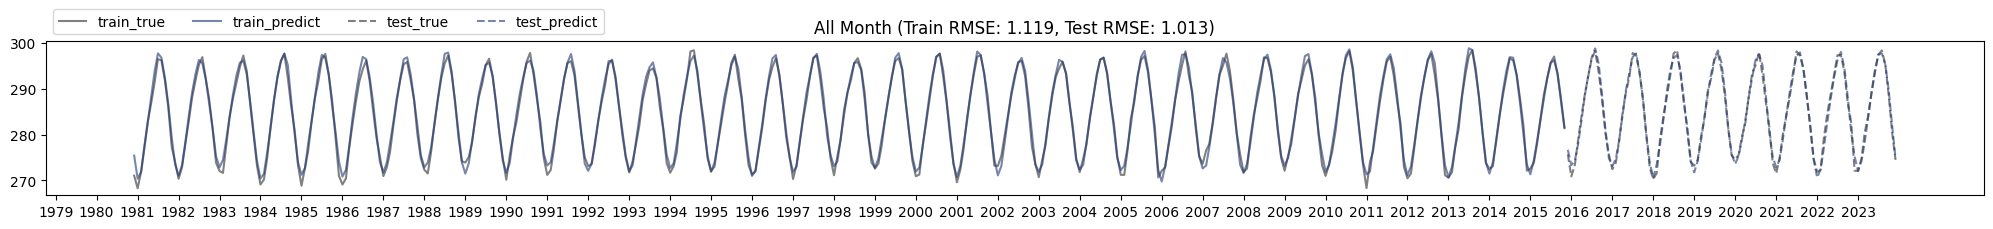

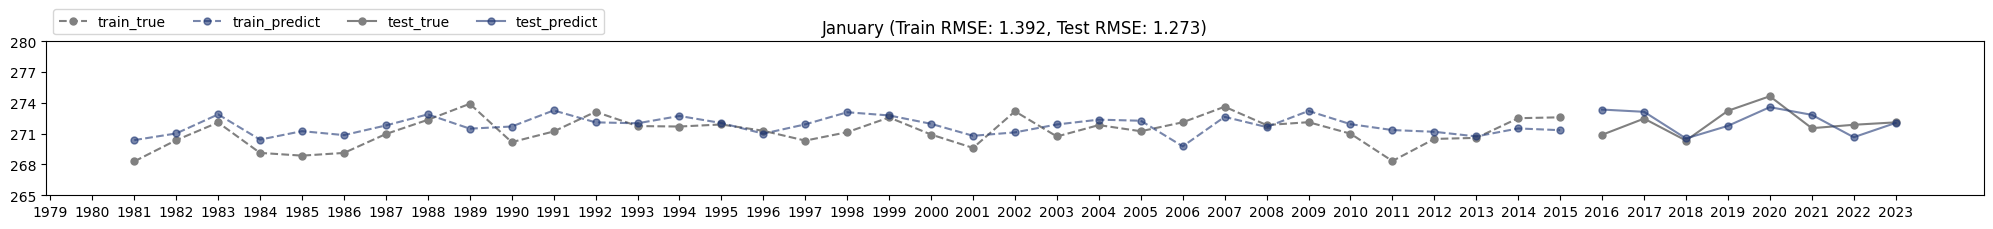

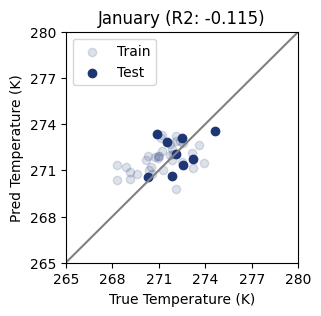

=========January=========
r2_score : -0.115
MAE      : 1.074646
RMSE     : 1.270721


In [82]:
bound = int((len(train_time)/12 -1) *12)
tot = -len(test_time.year.unique())  # test year

# col = (0., 70/255, 42/255)
col = (30/255, 54/255, 115/255)
plt.figure(figsize=(25,2))

plt.plot(tmp.iloc[:bound]['True'], c='grey', label='train_true')
plt.plot(tmp.iloc[:bound]['Predict'], c=col, alpha=0.6, label='train_predict')
plt.plot(tmp.iloc[bound:]['True'], '--', c='grey', label='test_true')
plt.plot(tmp.iloc[bound:]['Predict'], '--', c=col, alpha=0.6, label='test_predict')
plt.legend(bbox_to_anchor=(0, 1, 1, 0), loc="lower left", ncol=4)
plt.xticks(all_time[::12], labels=np.arange(all_time[0].year,all_time[-1].year+1))
rmse_totr = sqrt(mean_squared_error(tmp.iloc[:bound]['True'], tmp.iloc[:bound]['Predict']))
rmse_tote = sqrt(mean_squared_error(tmp.iloc[bound:]['True'], tmp.iloc[bound:]['Predict']))
plt.title('All Month'+' (Train RMSE: '+str(np.round(rmse_totr,3))+', Test RMSE: '+str(np.round(rmse_tote,3))+')')
plt.show()


rmse_trains = []; rmse_tests = []

for mo,l in zip([1], ['January']):
    plt.figure(figsize=(25,2))

    plt.plot(tmp.iloc[mo:bound:12]['True'], 'o--',markersize=5, c='grey', label='train_true')
    plt.plot(tmp.iloc[mo:bound:12]['Predict'], 'o--', markersize=5, c=col, alpha=0.6, label='train_predict')
    plt.plot(tmp.iloc[bound+mo::12]['True'], 'o-', markersize=5, c='grey', label='test_true')
    plt.plot(tmp.iloc[bound+mo::12]['Predict'], 'o-', markersize=5, c=col, alpha=0.6, label='test_predict')
    plt.legend(bbox_to_anchor=(0, 1, 1, 0), loc="lower left", ncol=4)
    plt.xticks(all_time[::12], labels=np.arange(all_time[0].year,all_time[-1].year+1))
    plt.yticks(np.arange(265, 281, 3))  # 1월 켈빈 온도 범위

    rmse_tr = sqrt(mean_squared_error(tmp.iloc[mo:bound:12]['True'], tmp.iloc[mo:bound:12]['Predict']))
    rmse_te = sqrt(mean_squared_error(tmp.iloc[bound+mo::12]['True'], tmp.iloc[bound+mo::12]['Predict']))
    rmse_trains.append(rmse_tr); rmse_tests.append(rmse_te)

    plt.title(l+' (Train RMSE: '+str(np.round(rmse_tr,3))+', Test RMSE: '+str(np.round(rmse_te,3))+')')
    plt.show()

plt.figure(figsize=(3,3))
plt.xlim([265,280])  # 1월 온도 범위
plt.ylim([265,280])
plt.plot(np.arange(265,280.1,5), np.arange(265,280.1,5), c='grey')
plt.scatter(tmp['True'].iloc[1::12][:tot], tmp['Predict'].iloc[1::12][:tot], c=col, alpha=0.15, label='Train')
plt.scatter(tmp['True'].iloc[1::12][tot:], tmp['Predict'].iloc[1::12][tot:], c=col, label='Test')
plt.xticks(np.arange(265,280.1,3)); plt.yticks(np.arange(265,280.1,3))
plt.xlabel('True Temperature (K)'); plt.ylabel('Pred Temperature (K)')
plt.legend()
y1 = tmp['True'].iloc[1::12][tot:]
yhat1 = tmp['Predict'].iloc[1::12][tot:]
plt.title('January (R2: '+str(np.round(r2_score(y1, yhat1),3))+')')
plt.show()

y1 = tmp['True'].iloc[1::12][tot:]
yhat1 = tmp['Predict'].iloc[1::12][tot:]
print('=========January=========')
print('r2_score : {:.3f}' .format(r2_score(y1, yhat1)))
print('MAE      : {:.6f}' .format(mean_absolute_error(y1, yhat1)))
print('RMSE     : {:.6f}' .format(np.sqrt(mean_squared_error(y1, yhat1))))

### 3) Dot plot

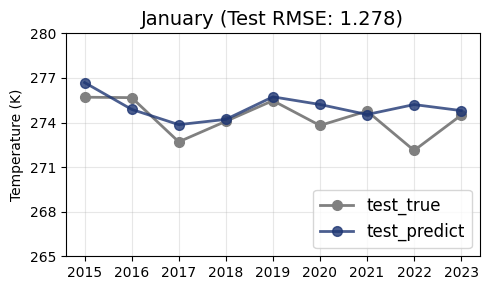

=========January Test Data=========
RMSE     : 1.278 K
MAE      : 0.929 K
R² Score : -0.123
실제 온도 범위: 272.1 ~ 275.7 K
예측 온도 범위: 273.9 ~ 276.7 K


In [83]:
# 1월 데이터 시계열 그래프 (켈빈 온도)
plt.figure(figsize=(5, 3))

# 1월 테스트 데이터 추출
test_true = tmp.iloc[bound::12]['True']  # 1월은 index 0
test_pred = tmp.iloc[bound::12]['Predict']

# 시계열 플롯
plt.plot(range(len(test_true)), test_true, 'o-', markersize=7, c='grey', label='test_true', linewidth=2)
plt.plot(range(len(test_pred)), test_pred, 'o-', markersize=7, c=col, alpha=0.8, label='test_predict', linewidth=2)

# 범례
plt.legend(loc='lower right', fontsize=12)

# x축 설정 (테스트 연도)
test_years = test_time.year.unique()
plt.xticks(range(len(test_years)), labels=test_years)

# y축 설정 (켈빈 온도 - 겨울철 범위)
plt.ylim([265, 280])  # 1월 기온 범위
plt.yticks(np.arange(265, 281, 3))  # 3도 간격
plt.ylabel('Temperature (K)')

# RMSE 계산
rmse_te = sqrt(mean_squared_error(test_true, test_pred))

# 제목
plt.title(f'January (Test RMSE: {rmse_te:.3f})', fontsize=14)

# 그리드
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# 성능 지표 출력
print('=========January Test Data=========')
print(f'RMSE     : {rmse_te:.3f} K')
print(f'MAE      : {mean_absolute_error(test_true, test_pred):.3f} K')
print(f'R² Score : {r2_score(test_true, test_pred):.3f}')
print(f'실제 온도 범위: {test_true.min():.1f} ~ {test_true.max():.1f} K')
print(f'예측 온도 범위: {test_pred.min():.1f} ~ {test_pred.max():.1f} K')